# Team Workload Optimization Models

**Business Objective (BO)**: Optimize Team Workloads  
**Goal**: Balance task assignments to prevent overburdening team members.

**Models to implement**:
1. **K-Means (Unsupervised - Clustering)**:
   - Why? Cluster team members (Assigned To) by workload metrics (Hours Spent, Task Count)
   - Features: Aggregated per-team-member: Total Hours, Pending Tasks, Avg Progress

2. **Linear Regression (Supervised - Regression)**:
   - Why? Predict future workload (e.g., "Charlie will spend 40+ hours next month")
   - Features: Historical Hours Spent, Task Count, Project Type
   - Target: Predicted hours per team member

3. **SVM (Supervised - Classification) (Optional)**:
   - Why? Classify team members as "Overloaded" or "Balanced" (if labeled data exists)

**Output**:
- Workload clusters (e.g., "Overloaded", "Underutilized")
- Forecasted hours to redistribute tasks fairly

## 1. Import Libraries

In [ ]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# K-Means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Linear Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# SVM (optional)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore the Dataset

In [ ]:
# Load the dataset
df = pd.read_csv('/modified_project_management_dataset.csv')

# Display the first few rows
df.head()

,Project ID,Project Name,Project Type,Start Date,End Date,Project Status,Priority,Task ID,Task Name,Task Status,Assigned To,Hours Spent,Progress
0,P001,Renovation of a School Project 001,Renovation,21/07/2024,08/08/2024,Behind,Medium,T001,Task 001 of Renovation of a School Project 001,In Progress,Bob,12,0.24
1,P001,Renovation of a School Project 001,Renovation,21/07/2024,12/08/2024,Behind,High,T002,Task 002 of Renovation of a School Project 001,In Progress,Charlie,4,0.56
2,P001,Renovation of a School Project 001,Renovation,21/07/2024,10/08/2024,Behind,High,T003,Task 003 of Renovation of a School Project 001,Completed,Charlie,5,1.00
3,P002,Innovation of a Classroom Project 002,Innovation,04/06/2024,12/07/2025,On Track,High,T001,Task 001 of Innovation of a Classroom Project 002,Pending,Charlie,24,0.33
4,P002,Innovation of a Classroom Project 002,Innovation,04/06/2024,26/06/2025,On Track,Medium,T002,Task 002 of Innovation of a Classroom Project 002,Pending,Charlie,26,0.32


In [ ]:
# Check dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Project ID      300 non-null    object 
 1   Project Name    300 non-null    object 
 2   Project Type    300 non-null    object 
 3   Start Date      300 non-null    object 
 4   End Date        300 non-null    object 
 5   Project Status  300 non-null    object 
 6   Priority        300 non-null    object 
 7   Task ID         300 non-null    object 
 8   Task Name       300 non-null    object 
 9   Task Status     300 non-null    object 
 10  Assigned To     300 non-null    object 
 11  Hours Spent     300 non-null    int64  
 12  Progress        300 non-null    float64
dtypes: float64(1), int64(1), object(11)
memory usage: 30.6+ KB


In [ ]:
# Check for missing values
df.isnull().sum()

,0
Project ID,0
Project Name,0
Project Type,0
Start Date,0
End Date,0
Project Status,0
Priority,0
Task ID,0
Task Name,0
Task Status,0


In [ ]:
# Check unique values in Assigned To
df['Assigned To'].value_counts()

,count
Assigned To,
Charlie,60
Alice,54
Eve,42
Ivy,39
Grace,38
David,26
Bob,25
Frank,16


## 3. Data Visualization and Exploration

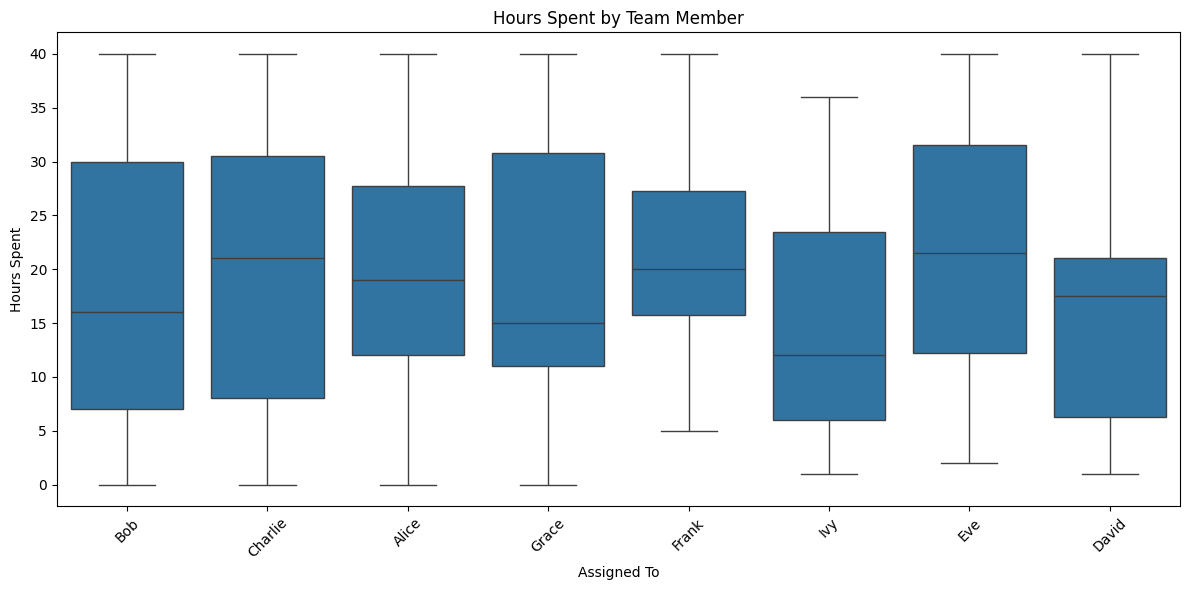

In [ ]:
# Visualize the distribution of Hours Spent by team member
plt.figure(figsize=(12, 6))
sns.boxplot(x='Assigned To', y='Hours Spent', data=df)
plt.title('Hours Spent by Team Member')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

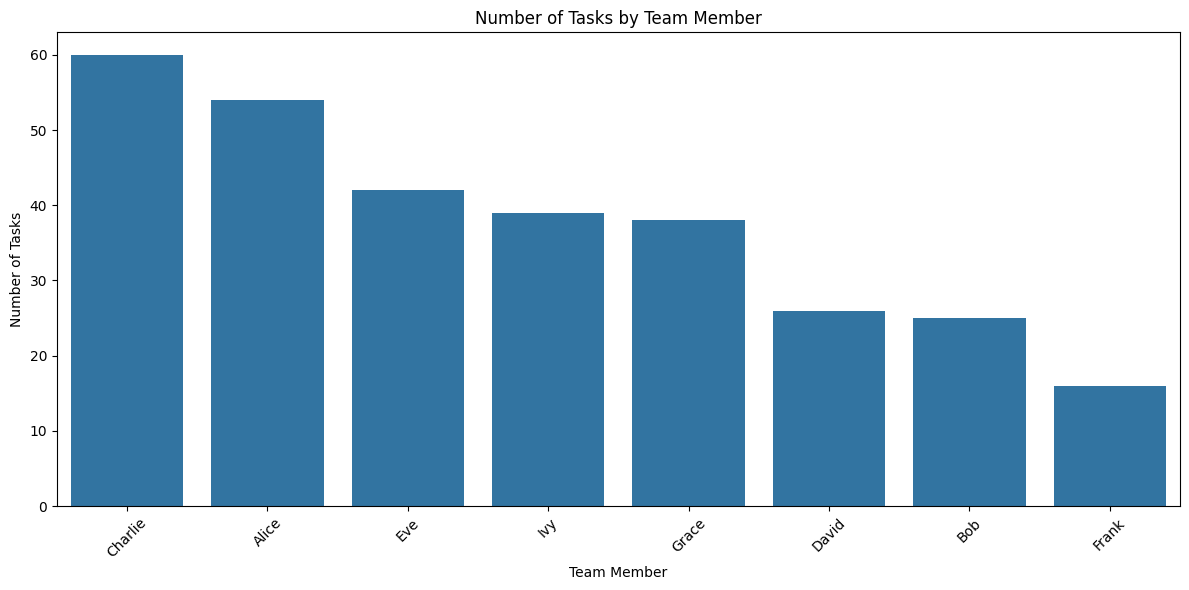

In [ ]:
# Visualize the count of tasks by team member
plt.figure(figsize=(12, 6))
task_counts = df['Assigned To'].value_counts()
sns.barplot(x=task_counts.index, y=task_counts.values)
plt.title('Number of Tasks by Team Member')
plt.xlabel('Team Member')
plt.ylabel('Number of Tasks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

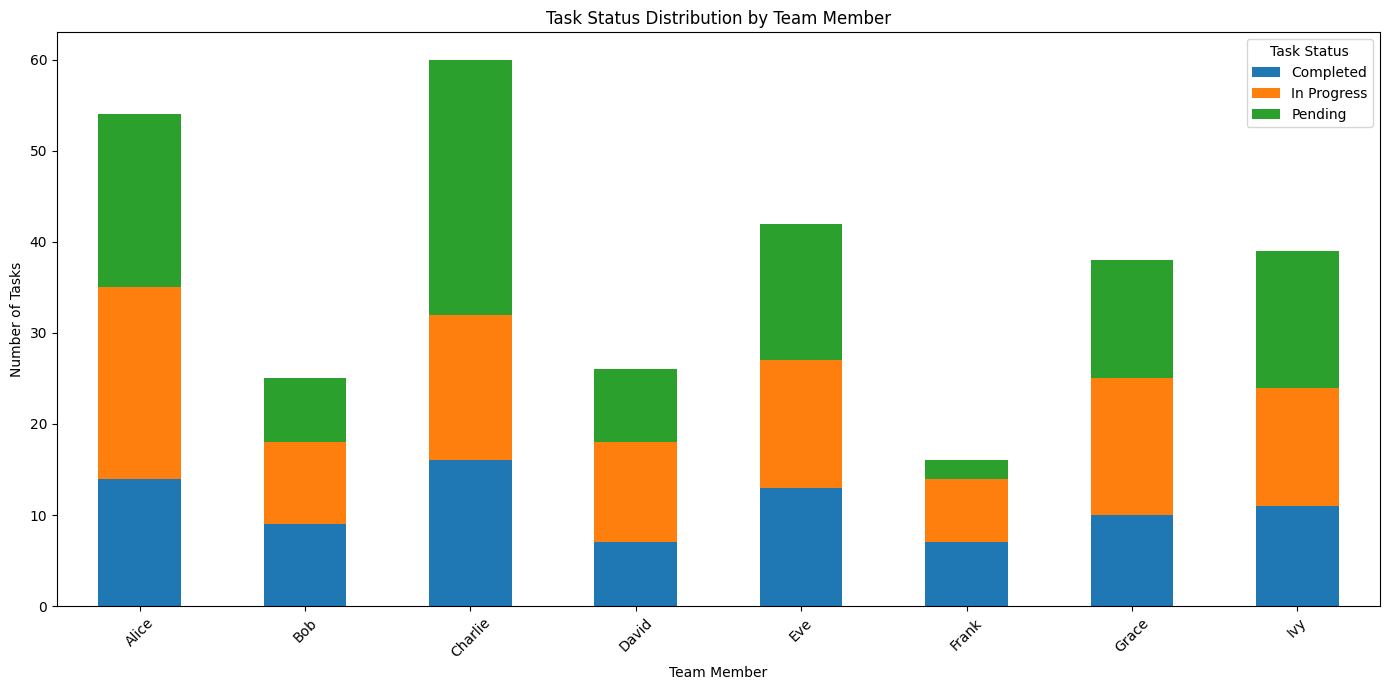

In [ ]:
# Visualize the distribution of task status by team member
plt.figure(figsize=(14, 7))
task_status_by_member = pd.crosstab(df['Assigned To'], df['Task Status'])
task_status_by_member.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Task Status Distribution by Team Member')
plt.xlabel('Team Member')
plt.ylabel('Number of Tasks')
plt.xticks(rotation=45)
plt.legend(title='Task Status')
plt.tight_layout()
plt.show()

## 4. Data Aggregation for Team Workload Analysis

We need to aggregate the data by team member to analyze workload patterns.

In [ ]:
# Aggregate data by team member
team_workload = df.groupby('Assigned To').agg({
    'Hours Spent': 'sum',  # Total hours spent by each team member
    'Task ID': 'count',    # Total number of tasks assigned
    'Progress': 'mean'     # Average progress across all tasks
}).reset_index()

# Rename columns for clarity
team_workload.rename(columns={
    'Hours Spent': 'Total_Hours',
    'Task ID': 'Task_Count',
    'Progress': 'Avg_Progress'
}, inplace=True)

# Display the aggregated data
team_workload

,Assigned To,Total_Hours,Task_Count,Avg_Progress
0,Alice,1060,54,0.596852
1,Bob,473,25,0.711200
2,Charlie,1244,60,0.615833
3,David,436,26,0.605769
4,Eve,884,42,0.659286
5,Frank,337,16,0.639375
6,Grace,721,38,0.640789
7,Ivy,608,39,0.662564


In [ ]:
# Calculate pending tasks per team member
pending_tasks = df[df['Task Status'] != 'Completed'].groupby('Assigned To').size().reset_index(name='Pending_Tasks')

# Merge with the team_workload dataframe
team_workload = team_workload.merge(pending_tasks, on='Assigned To', how='left')

# Fill NaN values with 0 (team members with no pending tasks)
team_workload['Pending_Tasks'].fillna(0, inplace=True)
team_workload['Pending_Tasks'] = team_workload['Pending_Tasks'].astype(int)

# Display the updated dataframe
team_workload

<ipython-input-10-6b95b4965b86>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  team_workload['Pending_Tasks'].fillna(0, inplace=True)


,Assigned To,Total_Hours,Task_Count,Avg_Progress,Pending_Tasks
0,Alice,1060,54,0.596852,40
1,Bob,473,25,0.711200,16
2,Charlie,1244,60,0.615833,44
3,David,436,26,0.605769,19
4,Eve,884,42,0.659286,29
5,Frank,337,16,0.639375,9
6,Grace,721,38,0.640789,28
7,Ivy,608,39,0.662564,28


In [ ]:
# Calculate additional workload metrics
team_workload['Hours_Per_Task'] = team_workload['Total_Hours'] / team_workload['Task_Count']
team_workload['Workload_Index'] = (team_workload['Total_Hours'] * (1 + team_workload['Pending_Tasks'] / team_workload['Task_Count']))

# Display the updated dataframe with new metrics
team_workload

,Assigned To,Total_Hours,Task_Count,Avg_Progress,Pending_Tasks,Hours_Per_Task,Workload_Index
0,Alice,1060,54,0.596852,40,19.629630,1845.185185
1,Bob,473,25,0.711200,16,18.920000,775.720000
2,Charlie,1244,60,0.615833,44,20.733333,2156.266667
3,David,436,26,0.605769,19,16.769231,754.615385
4,Eve,884,42,0.659286,29,21.047619,1494.380952
5,Frank,337,16,0.639375,9,21.062500,526.562500
6,Grace,721,38,0.640789,28,18.973684,1252.263158
7,Ivy,608,39,0.662564,28,15.589744,1044.512821


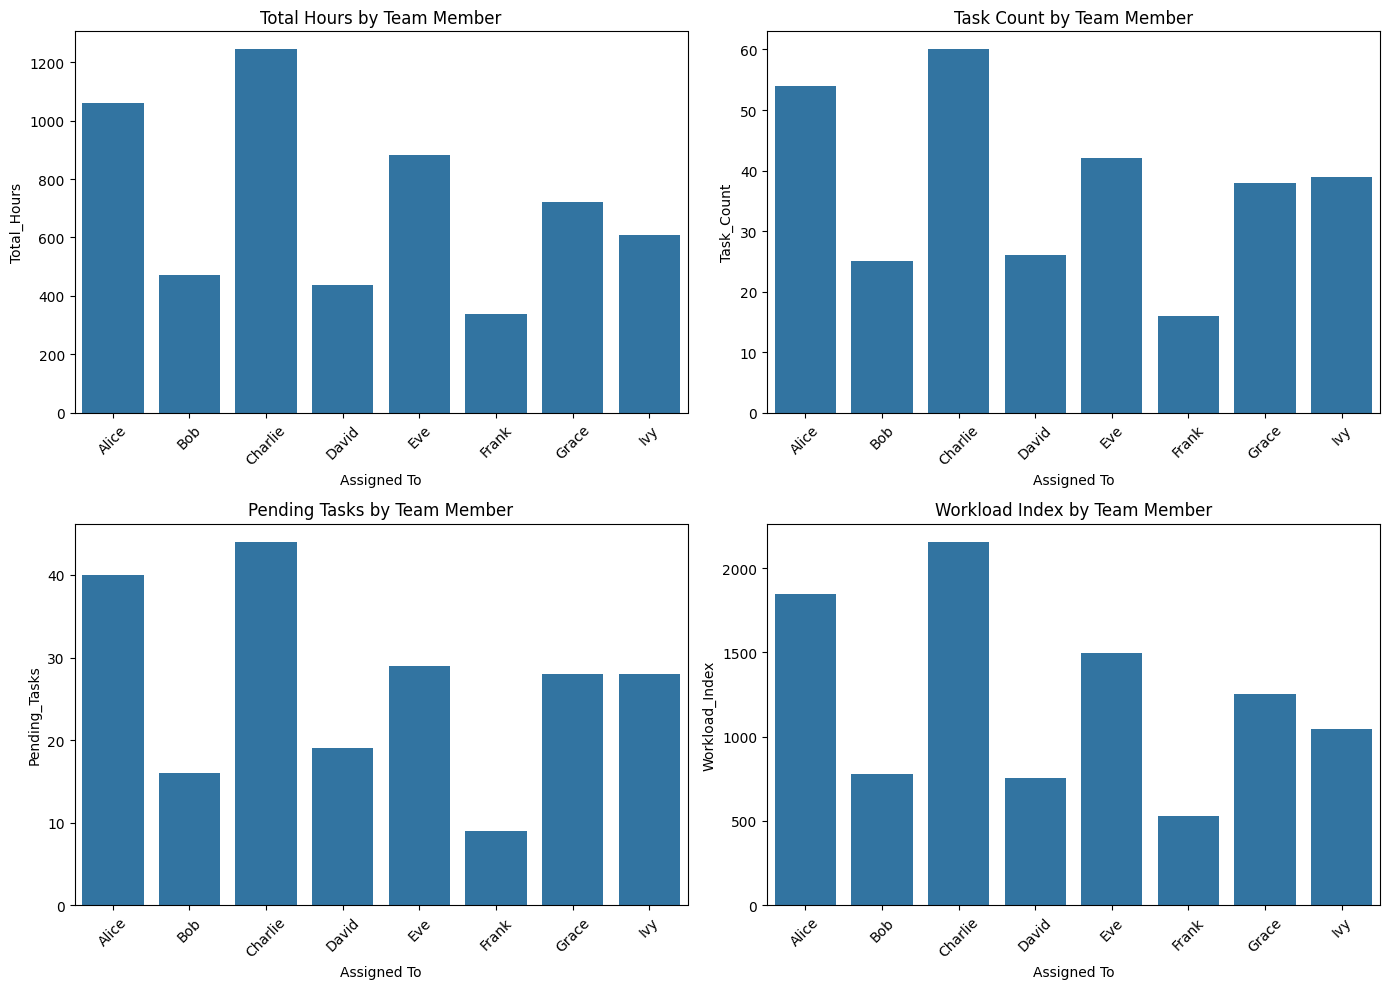

In [ ]:
# Visualize the workload metrics
plt.figure(figsize=(14, 10))

# Total Hours
plt.subplot(2, 2, 1)
sns.barplot(x='Assigned To', y='Total_Hours', data=team_workload)
plt.title('Total Hours by Team Member')
plt.xticks(rotation=45)

# Task Count
plt.subplot(2, 2, 2)
sns.barplot(x='Assigned To', y='Task_Count', data=team_workload)
plt.title('Task Count by Team Member')
plt.xticks(rotation=45)

# Pending Tasks
plt.subplot(2, 2, 3)
sns.barplot(x='Assigned To', y='Pending_Tasks', data=team_workload)
plt.title('Pending Tasks by Team Member')
plt.xticks(rotation=45)

# Workload Index
plt.subplot(2, 2, 4)
sns.barplot(x='Assigned To', y='Workload_Index', data=team_workload)
plt.title('Workload Index by Team Member')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 5. Prepare Data for Modeling

Scale the features for clustering and regression analysis.

In [ ]:
# Select features for clustering
clustering_features = ['Total_Hours', 'Task_Count', 'Pending_Tasks', 'Avg_Progress']

# Create a copy of the data with selected features
X_cluster = team_workload[clustering_features].copy()

# Scale the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Create a DataFrame with scaled features for better visualization
X_cluster_scaled_df = pd.DataFrame(X_cluster_scaled, columns=clustering_features)
X_cluster_scaled_df['Assigned To'] = team_workload['Assigned To'].values

# Display the scaled features
X_cluster_scaled_df

,Total_Hours,Task_Count,Pending_Tasks,Avg_Progress,Assigned To
0,1.133683,1.184631,1.213483,-1.290914,Alice
1,-0.825748,-0.897448,-0.963982,2.018308,Bob
2,1.747883,1.615406,1.576393,-0.741592,Charlie
3,-0.949256,-0.825652,-0.691799,-1.032846,David
4,0.546187,0.323081,0.215478,0.515915,Eve
5,-1.279722,-1.543610,-1.599075,-0.060299,Frank
6,0.002086,0.035898,0.124751,-0.019364,Grace
7,-0.375113,0.107694,0.124751,0.610791,Ivy


## 6. K-Means Clustering for Team Workload Analysis

Use K-Means clustering to identify groups of team members with similar workload patterns.

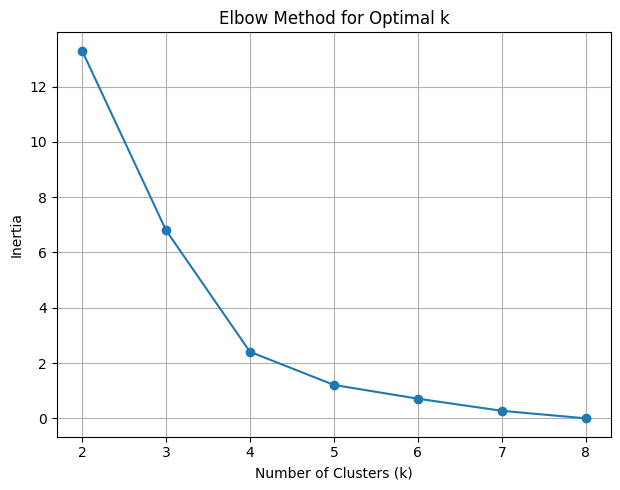

In [ ]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, min(10, len(team_workload) + 1))  # Limit to number of team members

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

    # Calculate silhouette score (only if we have enough samples)
    if len(team_workload) > k:
        silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# Plot the Elbow Method results
plt.figure(figsize=(12, 5))

# Inertia plot
plt.subplot(1, 2, 1)
plt.plot(list(k_range), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)


plt.tight_layout()
plt.show()

In [ ]:
# Based on the elbow method and silhouette score, choose the optimal number of clusters
# For this example, let's say the optimal k is 3 (you should adjust based on your results)
optimal_k = 3  # Adjust this based on the elbow method results

# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

# Add cluster labels to the team_workload dataframe
team_workload['Cluster'] = cluster_labels

# Display the results
team_workload

,Assigned To,Total_Hours,Task_Count,Avg_Progress,Pending_Tasks,Hours_Per_Task,Workload_Index,Cluster
0,Alice,1060,54,0.596852,40,19.629630,1845.185185,2
1,Bob,473,25,0.711200,16,18.920000,775.720000,0
2,Charlie,1244,60,0.615833,44,20.733333,2156.266667,2
3,David,436,26,0.605769,19,16.769231,754.615385,1
4,Eve,884,42,0.659286,29,21.047619,1494.380952,0
5,Frank,337,16,0.639375,9,21.062500,526.562500,1
6,Grace,721,38,0.640789,28,18.973684,1252.263158,0
7,Ivy,608,39,0.662564,28,15.589744,1044.512821,0


In [ ]:
# Analyze the clusters
cluster_analysis = team_workload.groupby('Cluster').agg({
    'Total_Hours': 'mean',
    'Task_Count': 'mean',
    'Pending_Tasks': 'mean',
    'Avg_Progress': 'mean',
    'Workload_Index': 'mean',
    'Assigned To': 'count'  # Number of team members in each cluster
}).reset_index()

# Rename the 'Assigned To' column to 'Member_Count'
cluster_analysis.rename(columns={'Assigned To': 'Member_Count'}, inplace=True)

# Display the cluster analysis
cluster_analysis

,Cluster,Total_Hours,Task_Count,Pending_Tasks,Avg_Progress,Workload_Index,Member_Count
0,0,671.5,36.0,25.25,0.668460,1141.719233,4
1,1,386.5,21.0,14.00,0.622572,640.588942,2
2,2,1152.0,57.0,42.00,0.606343,2000.725926,2


In [ ]:
# Assign meaningful labels to the clusters based on workload characteristics
def assign_workload_label(cluster_id):
    # Get the characteristics of this cluster
    cluster_data = cluster_analysis[cluster_analysis['Cluster'] == cluster_id]

    # Determine the label based on workload metrics
    if cluster_data['Workload_Index'].values[0] > cluster_analysis['Workload_Index'].mean() * 1.2:
        return 'Overloaded'
    elif cluster_data['Workload_Index'].values[0] < cluster_analysis['Workload_Index'].mean() * 0.8:
        return 'Underutilized'
    else:
        return 'Balanced'

# Create a mapping from cluster ID to workload label
cluster_labels_map = {cluster_id: assign_workload_label(cluster_id)
                     for cluster_id in cluster_analysis['Cluster']}

# Add the workload label to the team_workload dataframe
team_workload['Workload_Status'] = team_workload['Cluster'].map(cluster_labels_map)

# Display the results
team_workload

,Assigned To,Total_Hours,Task_Count,Avg_Progress,Pending_Tasks,Hours_Per_Task,Workload_Index,Cluster,Workload_Status
0,Alice,1060,54,0.596852,40,19.629630,1845.185185,2,Overloaded
1,Bob,473,25,0.711200,16,18.920000,775.720000,0,Balanced
2,Charlie,1244,60,0.615833,44,20.733333,2156.266667,2,Overloaded
3,David,436,26,0.605769,19,16.769231,754.615385,1,Underutilized
4,Eve,884,42,0.659286,29,21.047619,1494.380952,0,Balanced
5,Frank,337,16,0.639375,9,21.062500,526.562500,1,Underutilized
6,Grace,721,38,0.640789,28,18.973684,1252.263158,0,Balanced
7,Ivy,608,39,0.662564,28,15.589744,1044.512821,0,Balanced


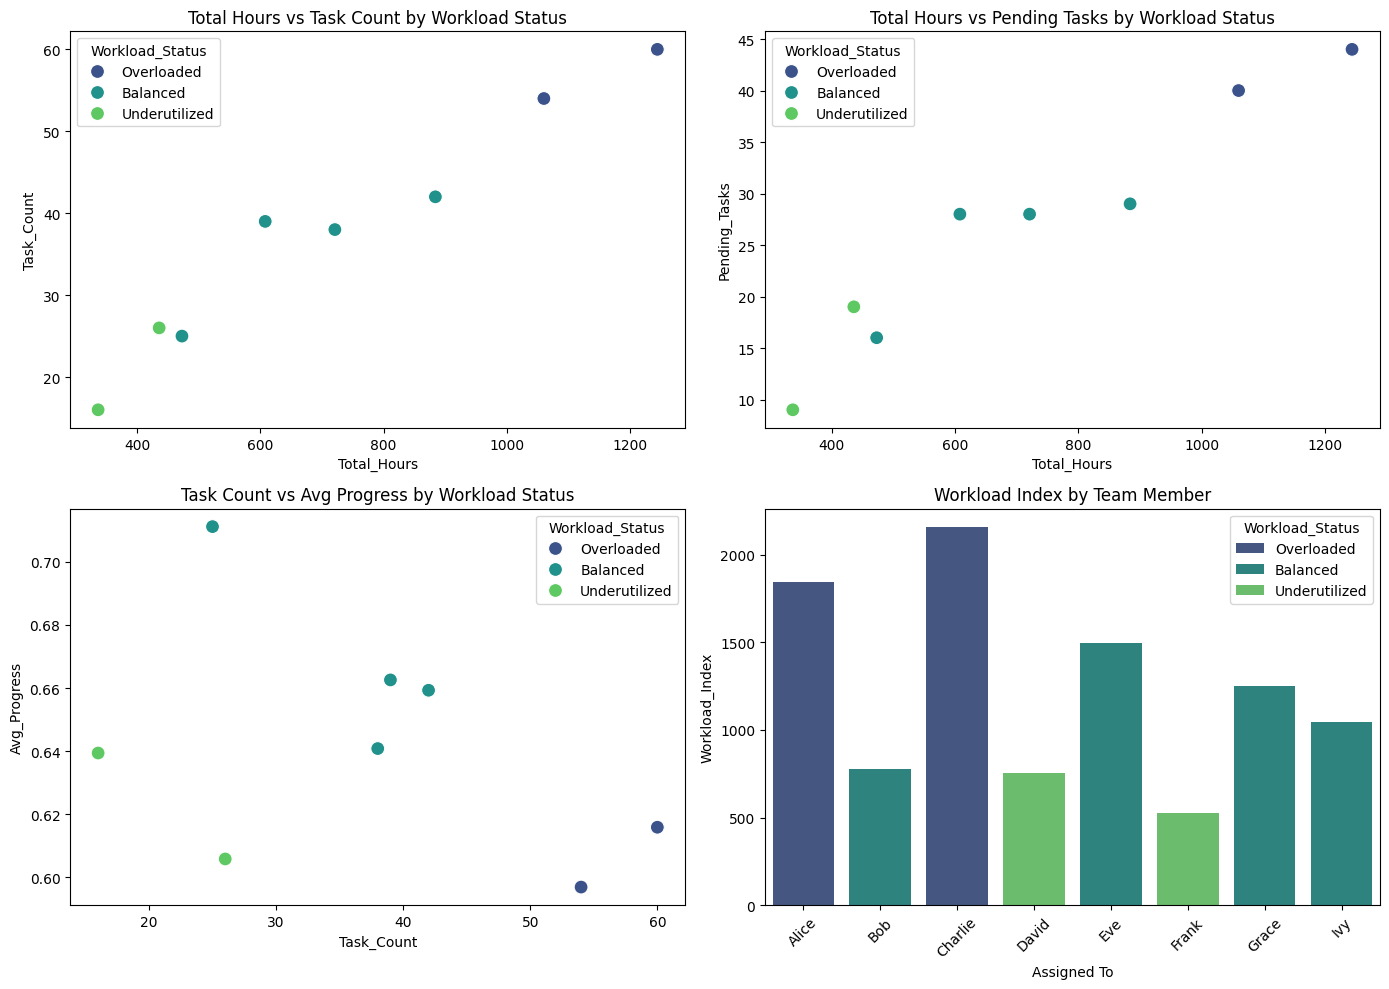

In [ ]:
# Visualize the clusters
plt.figure(figsize=(14, 10))

# Plot Total Hours vs Task Count
plt.subplot(2, 2, 1)
sns.scatterplot(x='Total_Hours', y='Task_Count', hue='Workload_Status',
                data=team_workload, s=100, palette='viridis')
plt.title('Total Hours vs Task Count by Workload Status')

# Plot Total Hours vs Pending Tasks
plt.subplot(2, 2, 2)
sns.scatterplot(x='Total_Hours', y='Pending_Tasks', hue='Workload_Status',
                data=team_workload, s=100, palette='viridis')
plt.title('Total Hours vs Pending Tasks by Workload Status')

# Plot Task Count vs Avg Progress
plt.subplot(2, 2, 3)
sns.scatterplot(x='Task_Count', y='Avg_Progress', hue='Workload_Status',
                data=team_workload, s=100, palette='viridis')
plt.title('Task Count vs Avg Progress by Workload Status')

# Plot Workload Index by Team Member
plt.subplot(2, 2, 4)
sns.barplot(x='Assigned To', y='Workload_Index', hue='Workload_Status',
            data=team_workload, palette='viridis')
plt.title('Workload Index by Team Member')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

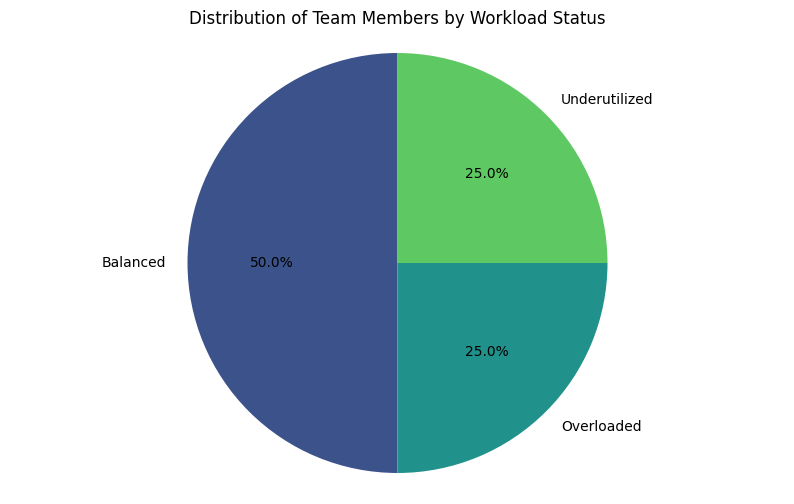

In [ ]:
# Count of team members in each workload status category
workload_status_counts = team_workload['Workload_Status'].value_counts()

# Visualize the distribution of workload status
plt.figure(figsize=(10, 6))
plt.pie(workload_status_counts, labels=workload_status_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette('viridis', len(workload_status_counts)))
plt.title('Distribution of Team Members by Workload Status')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

## 7. Linear Regression for Workload Prediction

Predict future workload (hours) for team members based on historical data.

In [ ]:
# For this part, we need to prepare data that simulates historical workload
# In a real scenario, you would have time-series data with timestamps
# For this example, we'll create a synthetic dataset based on the current data

# Let's assume we have data for the last 3 months (periods)
# We'll create a new dataframe with historical data

# First, get the list of team members
team_members = team_workload['Assigned To'].unique()

# Create a list to store the historical data
historical_data = []

# For each team member, create historical data for 3 periods
for team_member in team_members:
    # Get the current workload for this team member
    current_workload = team_workload[team_workload['Assigned To'] == team_member].iloc[0]

    # Create historical data with some random variation
    for period in range(1, 4):  # 3 historical periods
        # Add some random variation to the metrics
        variation_factor = np.random.uniform(0.8, 1.2)

        historical_data.append({
            'Assigned To': team_member,
            'Period': period,
            'Total_Hours': current_workload['Total_Hours'] * variation_factor,
            'Task_Count': int(current_workload['Task_Count'] * variation_factor),
            'Pending_Tasks': int(current_workload['Pending_Tasks'] * variation_factor),
            'Project_Type_Mix': np.random.choice(['Mostly Development', 'Mixed', 'Mostly Maintenance'])
        })

# Create a dataframe from the historical data
historical_df = pd.DataFrame(historical_data)

# Display the historical data
historical_df.head()

,Assigned To,Period,Total_Hours,Task_Count,Pending_Tasks,Project_Type_Mix
0,Alice,1,1006.805010,51,37,Mostly Development
1,Alice,2,925.776351,47,34,Mostly Development
2,Alice,3,1101.064467,56,41,Mixed
3,Bob,1,407.914163,21,13,Mostly Maintenance
4,Bob,2,465.289890,24,15,Mostly Development


In [ ]:
# Encode the Project_Type_Mix categorical variable
project_type_encoder = LabelEncoder()
historical_df['Project_Type_Encoded'] = project_type_encoder.fit_transform(historical_df['Project_Type_Mix'])

# Display the encoding mapping
print("Project Type Mix Encoding:")
for i, category in enumerate(project_type_encoder.classes_):
    print(f"{category}: {i}")

# Display the updated dataframe
historical_df.head()

Project Type Mix Encoding:
Mixed: 0
Mostly Development: 1
Mostly Maintenance: 2


,Assigned To,Period,Total_Hours,Task_Count,Pending_Tasks,Project_Type_Mix,Project_Type_Encoded
0,Alice,1,1006.805010,51,37,Mostly Development,1
1,Alice,2,925.776351,47,34,Mostly Development,1
2,Alice,3,1101.064467,56,41,Mixed,0
3,Bob,1,407.914163,21,13,Mostly Maintenance,2
4,Bob,2,465.289890,24,15,Mostly Development,1


In [ ]:
# Prepare features and target for linear regression
# Features: Period, Task_Count, Pending_Tasks, Project_Type_Encoded
# Target: Total_Hours

X_reg = historical_df[['Period', 'Task_Count', 'Pending_Tasks', 'Project_Type_Encoded']]
y_reg = historical_df['Total_Hours']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# Create and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Mean Squared Error: 5936.93
Root Mean Squared Error: 77.05
R² Score: 0.93
Mean Absolute Error: 67.45


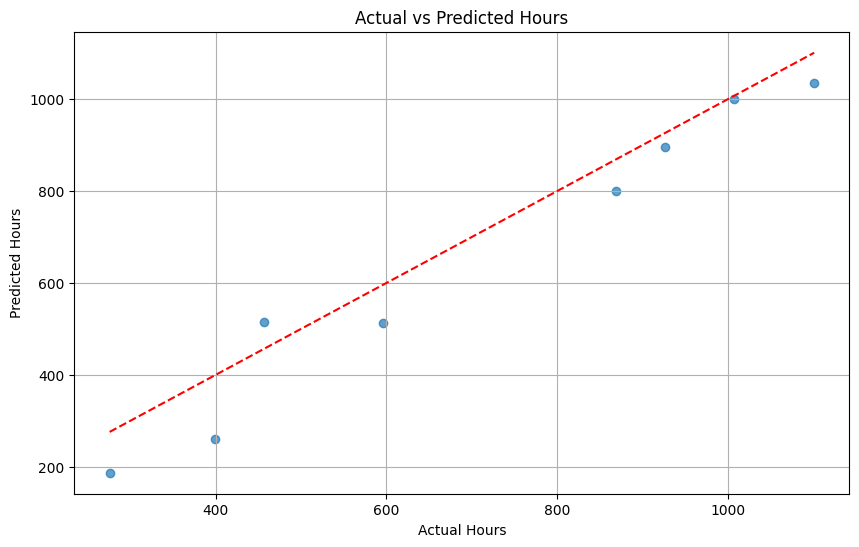

In [ ]:
# Visualize the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Hours')
plt.ylabel('Predicted Hours')
plt.title('Actual vs Predicted Hours')
plt.grid(True)
plt.show()

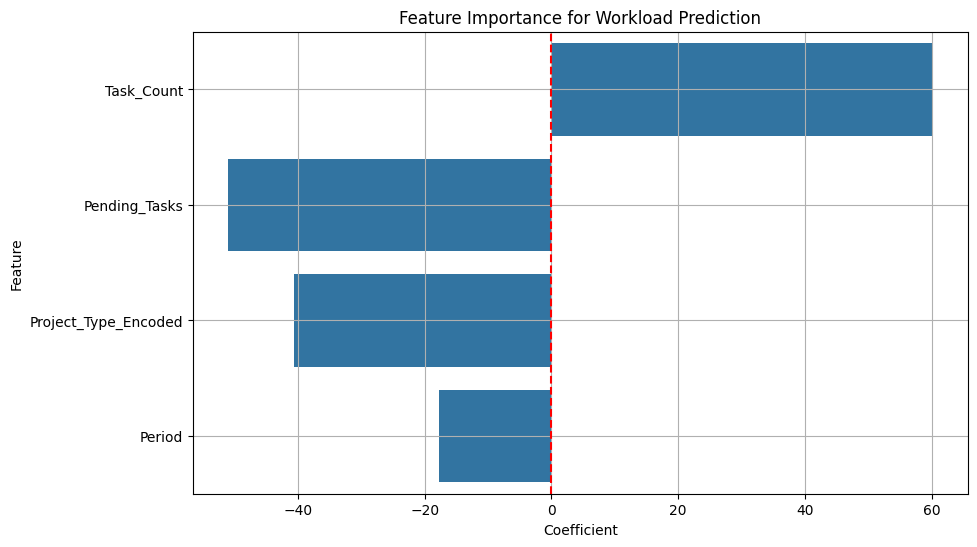

In [ ]:
# Analyze the coefficients to understand feature importance
feature_importance = pd.DataFrame({
    'Feature': X_reg.columns,
    'Coefficient': lr_model.coef_
})

# Sort by absolute coefficient value
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance for Workload Prediction')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

### Predict Future Workload for Team Members

Now let's predict the workload for the next period (Period 4) for each team member.

In [ ]:
# Create data for the next period (Period 4) for each team member
future_data = []

for team_member in team_members:
    # Get the current workload for this team member
    current_workload = team_workload[team_workload['Assigned To'] == team_member].iloc[0]

    # Assume task count and pending tasks will be similar to current period
    # In a real scenario, you might want to use time series forecasting for these values
    future_data.append({
        'Assigned To': team_member,
        'Period': 4,  # Next period
        'Task_Count': current_workload['Task_Count'],
        'Pending_Tasks': current_workload['Pending_Tasks'],
        'Project_Type_Mix': np.random.choice(['Mostly Development', 'Mixed', 'Mostly Maintenance'])
    })

# Create a dataframe for future predictions
future_df = pd.DataFrame(future_data)

# Encode the Project_Type_Mix
future_df['Project_Type_Encoded'] = project_type_encoder.transform(future_df['Project_Type_Mix'])

# Prepare the features for prediction
X_future = future_df[['Period', 'Task_Count', 'Pending_Tasks', 'Project_Type_Encoded']]

# Predict the hours for the next period
future_df['Predicted_Hours'] = lr_model.predict(X_future)

# Display the predictions
future_df[['Assigned To', 'Period', 'Task_Count', 'Pending_Tasks', 'Project_Type_Mix', 'Predicted_Hours']]

,Assigned To,Period,Task_Count,Pending_Tasks,Project_Type_Mix,Predicted_Hours
0,Alice,4,54,40,Mixed,1016.151399
1,Bob,4,25,16,Mostly Development,455.130884
2,Charlie,4,60,44,Mixed,1173.104527
3,David,4,26,19,Mixed,402.778177
4,Eve,4,42,29,Mixed,855.341194
5,Frank,4,16,9,Mixed,311.296353
6,Grace,4,38,28,Mixed,665.652415
7,Ivy,4,39,28,Mixed,725.832614


In [ ]:
# Merge the predictions with the current workload data
workload_prediction = team_workload.merge(
    future_df[['Assigned To', 'Predicted_Hours']],
    on='Assigned To',
    how='left'
)

# Calculate the predicted change in hours
workload_prediction['Hours_Change'] = workload_prediction['Predicted_Hours'] - workload_prediction['Total_Hours']
workload_prediction['Hours_Change_Pct'] = (workload_prediction['Hours_Change'] / workload_prediction['Total_Hours']) * 100

# Display the results
workload_prediction[['Assigned To', 'Total_Hours', 'Predicted_Hours', 'Hours_Change', 'Hours_Change_Pct', 'Workload_Status']]

,Assigned To,Total_Hours,Predicted_Hours,Hours_Change,Hours_Change_Pct,Workload_Status
0,Alice,1060,1016.151399,-43.848601,-4.136660,Overloaded
1,Bob,473,455.130884,-17.869116,-3.777826,Balanced
2,Charlie,1244,1173.104527,-70.895473,-5.698993,Overloaded
3,David,436,402.778177,-33.221823,-7.619684,Underutilized
4,Eve,884,855.341194,-28.658806,-3.241946,Balanced
5,Frank,337,311.296353,-25.703647,-7.627195,Underutilized
6,Grace,721,665.652415,-55.347585,-7.676503,Balanced
7,Ivy,608,725.832614,117.832614,19.380364,Balanced


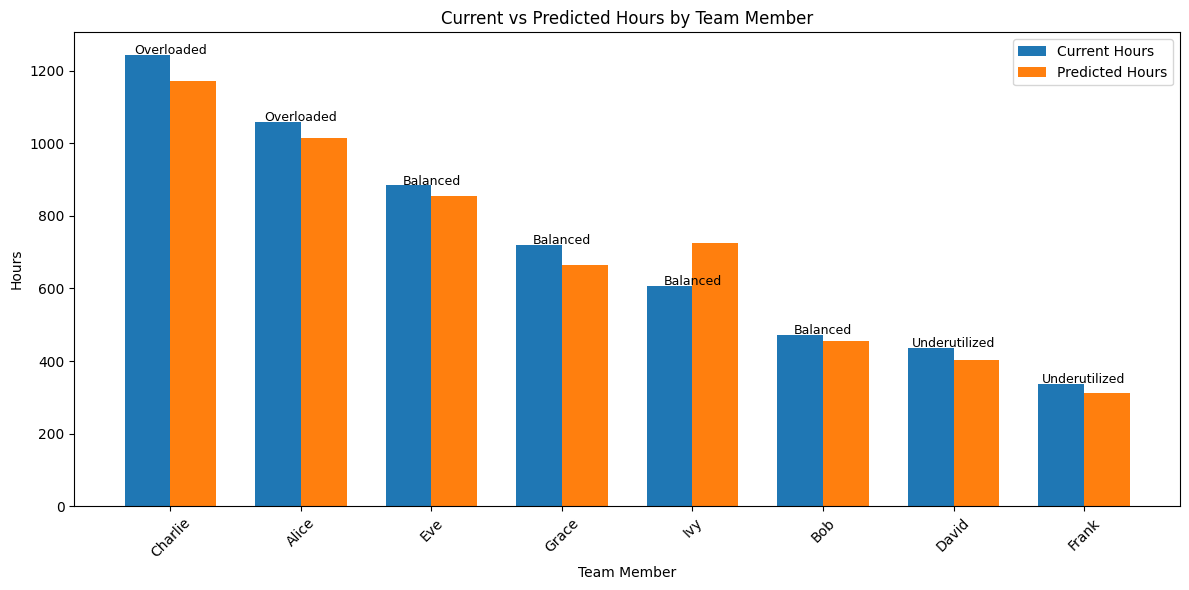

In [ ]:
# Visualize the current vs predicted hours
plt.figure(figsize=(12, 6))

# Sort by current workload for better visualization
sorted_data = workload_prediction.sort_values('Total_Hours', ascending=False)

# Create a bar chart
x = np.arange(len(sorted_data))
width = 0.35

plt.bar(x - width/2, sorted_data['Total_Hours'], width, label='Current Hours')
plt.bar(x + width/2, sorted_data['Predicted_Hours'], width, label='Predicted Hours')

plt.xlabel('Team Member')
plt.ylabel('Hours')
plt.title('Current vs Predicted Hours by Team Member')
plt.xticks(x, sorted_data['Assigned To'], rotation=45)
plt.legend()

# Add workload status as text above each bar
for i, status in enumerate(sorted_data['Workload_Status']):
    plt.text(i, sorted_data['Total_Hours'].iloc[i] + 2, status, ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## 8. SVM Classification for Workload Status

Classify team members as 'Overloaded' or 'Balanced' based on workload metrics.

In [ ]:
# Prepare data for SVM classification
# We'll use the workload metrics to classify team members as 'Overloaded' or 'Balanced'

# Create a binary target variable based on the Workload_Status
team_workload['Overloaded_Binary'] = team_workload['Workload_Status'].apply(
    lambda x: 1 if x == 'Overloaded' else 0
)

# Select features for classification
X_svm = team_workload[['Total_Hours', 'Task_Count', 'Pending_Tasks', 'Avg_Progress', 'Workload_Index']]
y_svm = team_workload['Overloaded_Binary']

# Scale the features
scaler_svm = StandardScaler()
X_svm_scaled = scaler_svm.fit_transform(X_svm)

# Since we have a small dataset, we'll use leave-one-out cross-validation
# This is appropriate when the dataset is very small
from sklearn.model_selection import LeaveOneOut

# Create SVM model
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Perform leave-one-out cross-validation
loo = LeaveOneOut()
y_pred_loo = []
y_true_loo = []

for train_index, test_index in loo.split(X_svm_scaled):
    X_train_loo, X_test_loo = X_svm_scaled[train_index], X_svm_scaled[test_index]
    y_train_loo, y_test_loo = y_svm.iloc[train_index], y_svm.iloc[test_index]

    # Train the model
    svm_model.fit(X_train_loo, y_train_loo)

    # Make prediction
    y_pred = svm_model.predict(X_test_loo)

    # Store the results
    y_pred_loo.append(y_pred[0])
    y_true_loo.append(y_test_loo.iloc[0])

# Calculate accuracy
accuracy = accuracy_score(y_true_loo, y_pred_loo)
print(f"Leave-One-Out Cross-Validation Accuracy: {accuracy:.2f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_true_loo, y_pred_loo, target_names=['Balanced', 'Overloaded']))

Leave-One-Out Cross-Validation Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

    Balanced       0.75      1.00      0.86         6
  Overloaded       0.00      0.00      0.00         2

    accuracy                           0.75         8
   macro avg       0.38      0.50      0.43         8
weighted avg       0.56      0.75      0.64         8



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Train the final SVM model on the entire dataset
final_svm_model = SVC(kernel='rbf', probability=True, random_state=42)
final_svm_model.fit(X_svm_scaled, y_svm)

# Get the support vectors
support_vectors = final_svm_model.support_vectors_

# Get the decision function values
decision_values = final_svm_model.decision_function(X_svm_scaled)

# Get the probabilities
probabilities = final_svm_model.predict_proba(X_svm_scaled)

# Add the probabilities to the team_workload dataframe
team_workload['Overload_Probability'] = probabilities[:, 1]  # Probability of being overloaded

# Display the results
team_workload[['Assigned To', 'Workload_Status', 'Overloaded_Binary', 'Overload_Probability']]

,Assigned To,Workload_Status,Overloaded_Binary,Overload_Probability
0,Alice,Overloaded,1,0.974353
1,Bob,Balanced,0,0.102558
2,Charlie,Overloaded,1,0.979810
3,David,Underutilized,0,0.102790
4,Eve,Balanced,0,0.102572
5,Frank,Underutilized,0,0.102720
6,Grace,Balanced,0,0.083271
7,Ivy,Balanced,0,0.059601


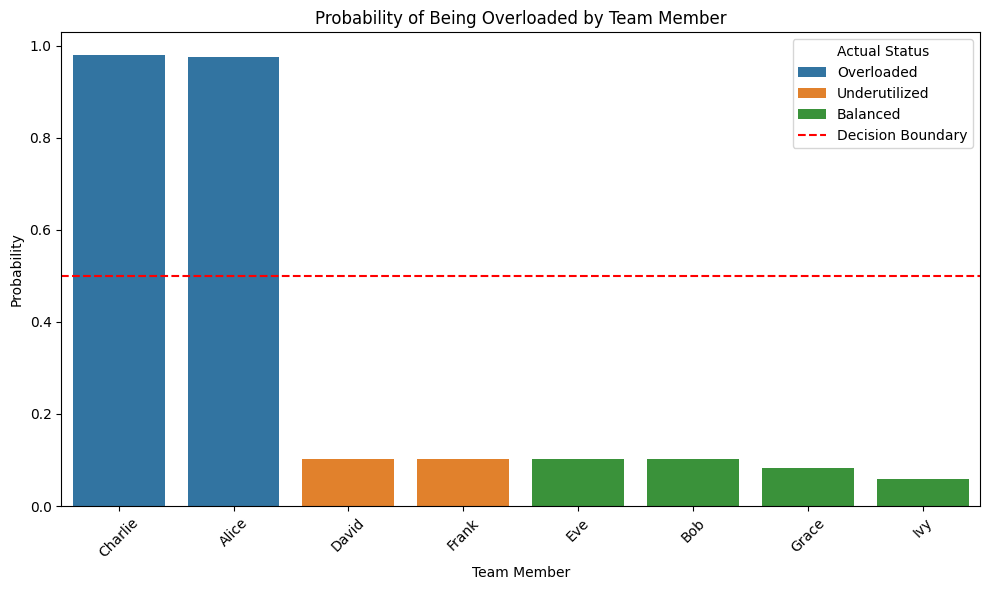

In [ ]:
# Visualize the SVM results
plt.figure(figsize=(10, 6))

# Sort by overload probability for better visualization
sorted_data = team_workload.sort_values('Overload_Probability', ascending=False)

# Create a bar chart of overload probabilities
sns.barplot(x='Assigned To', y='Overload_Probability', hue='Workload_Status', data=sorted_data)
plt.title('Probability of Being Overloaded by Team Member')
plt.xlabel('Team Member')
plt.ylabel('Probability')
plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Boundary')
plt.xticks(rotation=45)
plt.legend(title='Actual Status')
plt.tight_layout()
plt.show()

## 9. Model Comparison and Evaluation

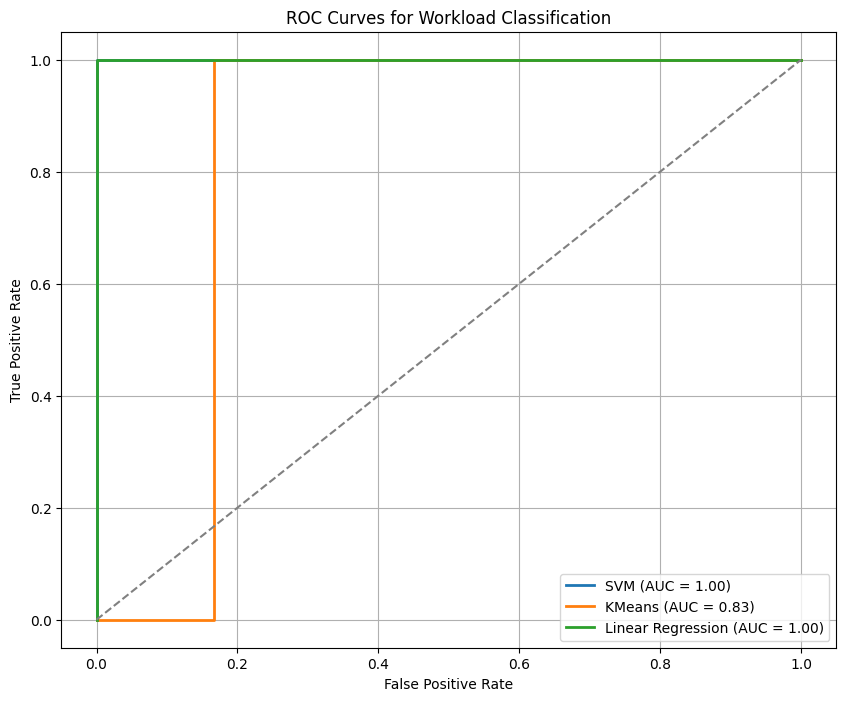

In [ ]:
# SVM Model  ===
team_workload['Overloaded_Binary'] = team_workload['Workload_Status'].apply(lambda x: 1 if x == 'Overloaded' else 0)
X_svm = team_workload[['Total_Hours', 'Task_Count', 'Pending_Tasks', 'Avg_Progress', 'Workload_Index']]
y_svm = team_workload['Overloaded_Binary']
scaler_svm = StandardScaler()
X_svm_scaled = scaler_svm.fit_transform(X_svm)

svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_svm_scaled, y_svm)
svm_proba = svm_model.predict_proba(X_svm_scaled)[:, 1]

# KMeans ROC  ===
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
X_cluster_scaled = scaler_svm.transform(X_svm)
kmeans.fit(X_cluster_scaled)
distances = kmeans.transform(X_cluster_scaled)
min_distances = np.min(distances, axis=1)

kmeans_scores = -min_distances

# Linear Regression ROC ===
X_reg = historical_df[['Period', 'Task_Count', 'Pending_Tasks', 'Project_Type_Encoded']]
y_reg = historical_df['Total_Hours']

merged = team_workload.merge(historical_df, on='Assigned To', suffixes=('', '_hist'))

X_test_lr = merged[['Period', 'Task_Count', 'Pending_Tasks', 'Project_Type_Encoded']]
X_test_lr_scaled = StandardScaler().fit_transform(X_test_lr)
y_test_lr_true = merged['Overloaded_Binary']  # True labels

lr_model = LinearRegression()
lr_model.fit(X_reg, y_reg)
y_lr_pred = lr_model.predict(X_test_lr)

# Plot ROC Curves ===
fpr_svm, tpr_svm, _ = roc_curve(y_svm, svm_proba)
fpr_kmeans, tpr_kmeans, _ = roc_curve(y_svm, kmeans_scores)
fpr_lr, tpr_lr, _ = roc_curve(y_test_lr_true, y_lr_pred)

auc_svm = auc(fpr_svm, tpr_svm)
auc_kmeans = auc(fpr_kmeans, tpr_kmeans)
auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})', lw=2)
plt.plot(fpr_kmeans, tpr_kmeans, label=f'KMeans (AUC = {auc_kmeans:.2f})', lw=2)
plt.plot(fpr_lr, tpr_lr, label=f'Linear Regression (AUC = {auc_lr:.2f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.title('ROC Curves for Workload Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 10. Recommendations for Workload Optimization

Based on our analysis, we can provide recommendations for optimizing team workloads.

In [ ]:
# Identify team members who are overloaded and those who are underutilized
overloaded_members = team_workload[team_workload['Workload_Status'] == 'Overloaded']['Assigned To'].tolist()
underutilized_members = team_workload[team_workload['Workload_Status'] == 'Underutilized']['Assigned To'].tolist()

# Identify team members whose workload is predicted to increase significantly
increasing_workload = workload_prediction[workload_prediction['Hours_Change_Pct'] > 10]['Assigned To'].tolist()

# Calculate total tasks that could be redistributed
overloaded_members_total_tasks = 0
if overloaded_members:
    overloaded_members_data = workload_prediction[workload_prediction['Assigned To'].isin(overloaded_members)]
    overloaded_members_total_tasks = overloaded_members_data['Pending_Tasks'].sum()
    tasks_to_redistribute = int(overloaded_members_total_tasks * 0.3)  # Redistribute 30% of pending tasks

# Generate recommendations
print("Workload Optimization Recommendations:\n")

if overloaded_members:
    print("Overloaded Team Members:")
    for member in overloaded_members:
        member_data = workload_prediction[workload_prediction['Assigned To'] == member].iloc[0]
        print(f"  - {member}: Currently has {member_data['Task_Count']} tasks and {member_data['Pending_Tasks']} pending tasks")
        if member in increasing_workload:
            print(f"    * Warning: Workload predicted to increase by {member_data['Hours_Change_Pct']:.1f}% in the next period")
        print(f"    * Recommendation: Redistribute {max(1, int(member_data['Pending_Tasks'] * 0.3))} tasks to underutilized team members")
    print()

if underutilized_members:
    print("Underutilized Team Members:")
    for member in underutilized_members:
        member_data = workload_prediction[workload_prediction['Assigned To'] == member].iloc[0]
        print(f"  - {member}: Currently has {member_data['Task_Count']} tasks and {member_data['Pending_Tasks']} pending tasks")
        capacity = int((overloaded_members_total_tasks * 0.3) / len(underutilized_members)) if overloaded_members else 0
        print(f"    * Recommendation: Can take on approximately {capacity} additional tasks")
    print()

if overloaded_members:
    print(f"Total tasks that could be redistributed: {tasks_to_redistribute}")

Workload Optimization Recommendations:

Overloaded Team Members:
  - Alice: Currently has 54 tasks and 40 pending tasks
    * Recommendation: Redistribute 12 tasks to underutilized team members
  - Charlie: Currently has 60 tasks and 44 pending tasks
    * Recommendation: Redistribute 13 tasks to underutilized team members

Underutilized Team Members:
  - David: Currently has 26 tasks and 19 pending tasks
    * Recommendation: Can take on approximately 12 additional tasks
  - Frank: Currently has 16 tasks and 9 pending tasks
    * Recommendation: Can take on approximately 12 additional tasks

Total tasks that could be redistributed: 25
